# 1.Setup

In [2]:
from pylab import *
%matplotlib inline
import sys
import caffe
import os
import PIL
import scipy.io as sio
import tempfile

In [3]:
nyud_root = '/home/yongyang/CVProjects/nyud'

In [4]:
weights = nyud_root+'/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

# 2.Load AlexNet and modify it to adjust the image size.

In [5]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='xavier', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='xavier', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

In [6]:
def alex_net(split, tops,is_train = True, num_classes = 14,classifier_name = 'scene_classifier'):
#     """Returns a NetSpec specifying CaffeNet, following the original proto text
#      specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""    
    n = caffe.NetSpec()
    n.data,n.label = L.Python(module='nyud_layers',
            layer='NYUDSegDataLayer', ntop=2,
            param_str=str(dict(nyud_dir=nyud_root+'/data_nyud', split=split,
                tops=tops, seed=1337)))
    param = frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6_new, n.relu6 = fc_relu(n.pool5, 4096, param=learned_param)
    if is_train: # train phase need dropout layer 
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:     # test phase no dropout
        fc7input = n.relu6
    n.fc7_new, n.relu7 = fc_relu(fc7input, 4096, param=learned_param)
    if is_train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not is_train:
        n.probs = L.Softmax(fc8)
    if n.label is not None:
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    return n.to_proto()

with open('alex_train.prototxt', 'w') as f:
    f.write(str(alex_net('train', ['color','sceneLabel'])))
with open('alex_val.prototxt', 'w') as f:
    f.write(str(alex_net('val', ['color','sceneLabel'],is_train = False)))
with open('alex_test.prototxt', 'w') as f:
    f.write(str(alex_net('test', ['color','sceneLabel'],is_train = False)))

In [7]:
caffe.set_mode_cpu()
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.AdamSolver('solver_adam.prototxt')
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1, 3, 425, 560)),
 ('label', (1, 1)),
 ('label_data_1_split_0', (1, 1)),
 ('label_data_1_split_1', (1, 1)),
 ('conv1', (1, 96, 104, 138)),
 ('pool1', (1, 96, 52, 69)),
 ('norm1', (1, 96, 52, 69)),
 ('conv2', (1, 256, 52, 69)),
 ('pool2', (1, 256, 26, 34)),
 ('norm2', (1, 256, 26, 34)),
 ('conv3', (1, 384, 26, 34)),
 ('conv4', (1, 384, 26, 34)),
 ('conv5', (1, 256, 26, 34)),
 ('pool5', (1, 256, 13, 17)),
 ('fc6_new', (1, 4096)),
 ('fc7_new', (1, 4096)),
 ('scene_classifier', (1, 14)),
 ('scene_classifier_scene_classifier_0_split_0', (1, 14)),
 ('scene_classifier_scene_classifier_0_split_1', (1, 14)),
 ('loss', ()),
 ('acc', ())]

In [8]:
print 'train',solver.net.forward()  # train net
print 'val',solver.test_nets[0].forward()  # test net (there can be more than one)
print 'test',solver.test_nets[1].forward()  # test net (there can be more than one)

train {'acc': array(0.0, dtype=float32), 'loss': array(2.6390573978424072, dtype=float32)}
val {'acc': array(0.0, dtype=float32), 'loss': array(2.6390573978424072, dtype=float32), 'probs': array([[ 0.07142857,  0.07142857,  0.07142857,  0.07142857,  0.07142857,
         0.07142857,  0.07142857,  0.07142857,  0.07142857,  0.07142857,
         0.07142857,  0.07142857,  0.07142857,  0.07142857]], dtype=float32)}
test {'acc': array(0.0, dtype=float32), 'loss': array(2.6390573978424072, dtype=float32), 'probs': array([[ 0.07142857,  0.07142857,  0.07142857,  0.07142857,  0.07142857,
         0.07142857,  0.07142857,  0.07142857,  0.07142857,  0.07142857,
         0.07142857,  0.07142857,  0.07142857,  0.07142857]], dtype=float32)}


# 3. Visualize the data

In [9]:
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [8]:
allSceneLabel =sio.loadmat('/home/yongyang/CVProjects/nyud/data/sceneLabel/imgAllScene.mat')

In [11]:
allSceneLabel.keys()

['sceneName', '__version__', 'gtScene', '__header__', '__globals__']

The scenery is  home_office


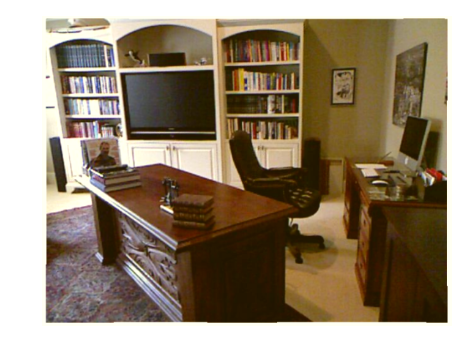

In [12]:
# Show the image here 
solver.net.forward()
imshow(deprocess_net_image(solver.net.blobs['data'].data[0])); axis('off')
index = int(solver.net.blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

The scenery is  basement


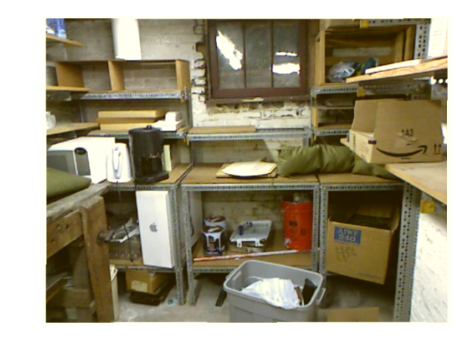

In [13]:
solver.test_nets[0].forward()
imshow(deprocess_net_image(solver.test_nets[0].blobs['data'].data[0]));axis('off')
index = int(solver.test_nets[0].blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

The scenery is  bathroom


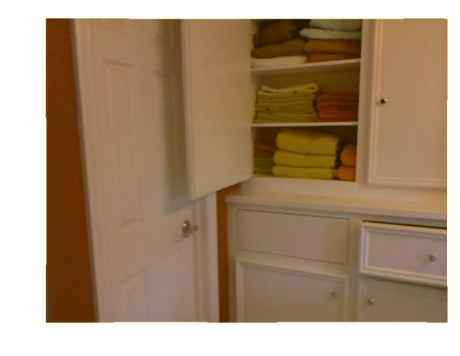

In [14]:
solver.test_nets[1].forward()
imshow(deprocess_net_image(solver.test_nets[1].blobs['data'].data[0]));axis('off')
index = int(solver.test_nets[1].blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

# 4. Training phase

In [10]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001,reg = 5e-4):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = reg

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = nyud_root + 'nyud-fcns-colr/alex/snapshot/train'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.CPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

In [11]:
def run_solver(niter,solver,disp_interval=20,test_interval = 200):
    """Run solver for niter iterations,returning loss and accuracy
    """
    loss = np.zeros(niter)
    train_acc_list = np.zeros(niter//test_interval+1)
    val_acc_list = np.zeros(niter//test_interval+1)
    for it in xrange(niter):
         # test phase
        if it%test_interval==0:            
            train_correct = 0 
            for i in range(500): # the number in train test is 364
                solver.net.forward()
                train_correct += sum(solver.net.blobs['scene_classifier'].data.argmax(1)
                       == solver.net.blobs['label'].data)
            train_acc = train_correct/500.
            train_acc_list[it//test_interval] = train_acc
            print 'number correct:',train_correct
            print 'train accuracy is %f'% train_acc  

            # validation phase
            correct = 0.
            for i in range(609): # the number in validation is 609
                solver.test_nets[0].forward()
                correct += sum(solver.test_nets[0].blobs['probs'].data.argmax(1)
                       == solver.test_nets[0].blobs['label'].data)
            val_acc = correct/609.
            val_acc_list[it//test_interval] = val_acc
            print 'number correct:',correct
            print 'validation accuracy is %f'% val_acc

            #if it>600:solver.snapshot()  # store training model
            
            if it//test_interval>0 and val_acc+0.03 < val_acc_list[it/test_interval-1]:break
        # training phase
        solver.step(1)
        loss[it] = solver.net.blobs['loss'].data.copy()
        if it % disp_interval== 0 :
            print 'iter %d loss is %f'%(it,loss[it])
       
                
    return loss,train_acc_list,val_acc_list

In [12]:
from caffe.proto import caffe_pb2
from google.protobuf import text_format
solver_config = caffe_pb2.SolverParameter()
with open('/home/yongyang/CVProjects/nyud/nyud-color/alex/solver.prototxt') as f:
    text_format.Merge(str(f.read()), solver_config)

In [13]:
# Modify solver parameters here
solver_config.base_lr = 1e-5
solver_config.weight_decay = 0.3
solver_config.iter_size = 20
solver_config.snapshot = 200

# write to file
new_solver_config = text_format.MessageToString(solver_config)
with open('temp_adam_solver.prototxt', 'w') as f:
    f.write(new_solver_config) 

In [15]:
# load weights from pretrained model
solver = caffe.AdamSolver('temp_adam_solver.prototxt')
solver.net.copy_from(weights)

In [16]:
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1, 3, 425, 560)),
 ('label', (1, 1)),
 ('label_data_1_split_0', (1, 1)),
 ('label_data_1_split_1', (1, 1)),
 ('conv1', (1, 96, 104, 138)),
 ('pool1', (1, 96, 52, 69)),
 ('norm1', (1, 96, 52, 69)),
 ('conv2', (1, 256, 52, 69)),
 ('pool2', (1, 256, 26, 34)),
 ('norm2', (1, 256, 26, 34)),
 ('conv3', (1, 384, 26, 34)),
 ('conv4', (1, 384, 26, 34)),
 ('conv5', (1, 256, 26, 34)),
 ('pool5', (1, 256, 13, 17)),
 ('fc6_new', (1, 4096)),
 ('fc7_new', (1, 4096)),
 ('scene_classifier', (1, 14)),
 ('scene_classifier_scene_classifier_0_split_0', (1, 14)),
 ('scene_classifier_scene_classifier_0_split_1', (1, 14)),
 ('loss', ()),
 ('acc', ())]

In [17]:
%%time
test_interval = 200
niter = 3001
print 'Running solvers for %d iterations.' % niter
train_loss,train_acc,val_acc = run_solver(niter, solver)
print 'Done.'

Running solvers for 3001 iterations.
number correct: 42
train accuracy is 0.084000
number correct: 52.0
validation accuracy is 0.085386
iter 0 loss is 2.639057
iter 20 loss is 2.415388
iter 40 loss is 2.434796
iter 60 loss is 2.399184
iter 80 loss is 2.945882
iter 100 loss is 2.745520
iter 120 loss is 2.871005
iter 140 loss is 1.852001
iter 160 loss is 2.360389
iter 180 loss is 2.027720
number correct: 222
train accuracy is 0.444000
number correct: 251.0
validation accuracy is 0.412151
iter 200 loss is 2.207162
iter 220 loss is 2.296576
iter 240 loss is 1.105739
iter 260 loss is 2.050870
iter 280 loss is 1.729083
iter 300 loss is 0.445295
iter 320 loss is 1.057380
iter 340 loss is 1.701687
iter 360 loss is 1.338725
iter 380 loss is 1.489111
number correct: 374
train accuracy is 0.748000
number correct: 354.0
validation accuracy is 0.581281
iter 400 loss is 1.928798
iter 420 loss is 1.691002
iter 440 loss is 0.489664
iter 460 loss is 0.638985
iter 480 loss is 0.529751
iter 500 loss is 0

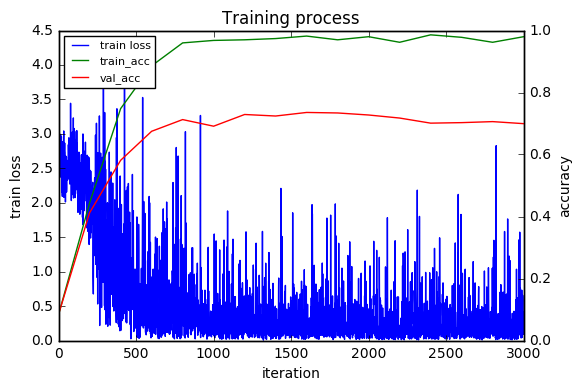

In [19]:
#plot train loss, train accuracy and validation accuracy during the training
test_interval = 200
niter = 3000
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter),train_loss[0:niter],label = 'train loss')
#ax1.set_ylim(0,10)
ax2.plot(test_interval* arange(len(train_acc[0:niter/test_interval+1])), train_acc[0:niter/test_interval+1],'-',label='train_acc', color ='g')
ax2.plot(test_interval* arange(len(val_acc[0:niter/test_interval+1])), val_acc[0:niter/test_interval+1],'-',label='val_acc', color='r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('accuracy')

ax1.set_title('Training process')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left',prop={'size':8})

# Test phase

caffe.set_mode_cpu()
solver = caffe.SGDSolver('temp.prototxt')
solver.restore('snapshot/train_iter_2000.solverstate')
solver.test_nets[0].share_with(solver.net)
solver.test_nets[1].share_with(solver.net)

In [24]:
del solver
solver = caffe.AdamSolver('temp_adam_solver.prototxt')
solver.restore('/home/yongyang/CVProjects/nyud/nyud-color/alex/snapshot/train_iter_1500.solverstate')
solver.test_nets[0].share_with(solver.net)
solver.test_nets[1].share_with(solver.net)

In [23]:
 # validation phase
correct = 0.
for i in range(609): # the number in validation is 609
    solver.test_nets[0].forward()
    correct += sum(solver.test_nets[0].blobs['probs'].data.argmax(1)
           == solver.test_nets[0].blobs['label'].data)
val_acc = correct/609.
#val_acc_list[it//test_interval] = val_acc
print 'number correct:',correct
print 'validation accuracy is %f'% val_acc


number correct: 403.0
validation accuracy is 0.661741


In [22]:
solver.step(100)
solver.snapshot()

In [16]:
%%time
niter = 375
output = zeros((niter, 1, 27))
ground_truth = zeros((niter,1,1))
correct = 0
# the main solver loop
print 'testing...'
for it in range(niter):
    # store the output on the first test batch
    # (start the forward pass at conv1
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
#  how to do it directly in Python, where more complicated things are easi
    
    solver.test_nets[1].forward()
    output[it] = solver.test_nets[1].blobs['probs'].data
    ground_truth[it] = solver.test_nets[1].blobs['label'].data
    correct += sum(solver.test_nets[1].blobs['probs'].data.argmax(1)
                   == solver.test_nets[1].blobs['label'].data)
test_acc = correct / 375.
print 'num_correct %d'%correct
print 'test accuracy: %f'%test_acc                                                                                                                         

testing...
num_correct 191
test accuracy: 0.509333
CPU times: user 2min 32s, sys: 1.06 s, total: 2min 33s
Wall time: 1min 19s


In [17]:
output.shape

(375, 1, 27)

In [18]:
ground_truth[9][0][0]

4.0

In [19]:
import pandas as pd

In [20]:
tran_txt = pd.read_csv('/home/yongyang/CVProjects/nyud/data/train.txt',header = None)
val_txt = pd.read_csv('/home/yongyang/CVProjects/nyud/data/val.txt',header = None)
test_txt = pd.read_csv('/home/yongyang/CVProjects/nyud/data/test.txt',header = None)

In [21]:
print len(tran_txt)
print len(val_txt)
print len(test_txt)

715
359
375


# Calculate the accuracy for all kinds of scenerys independently

In [22]:
scenes_lists = []
for i in xrange(27):
    scenes_lists.append([])
for i in xrange(ground_truth.shape[0]):
    scenes_lists[int(ground_truth[i][0][0])-1].append(i)

In [23]:
result = np.zeros((27,2))
for i in xrange(27):
    num = len(scenes_lists[i])
    accu = nan
    correct = 0.
    if num!=0:
        for j in range(num):
             correct += sum(output[scenes_lists[i][j]].argmax(1) == ground_truth[scenes_lists[i][j]])
        accu = correct/num
    result[i][0] = num
    result[i][1] = accu

In [24]:
result_pd = pd.DataFrame(result)
result_pd['scene_name'] = 'ok'
for i in xrange(27):
    result_pd['scene_name'][i]= allSceneLabel['sceneName'][0][i][0]
result_pd.columns = ['num','accuracy','scene_name']
result_pd = result_pd.set_index('scene_name',drop = True)
result_pd['num'] = result_pd['num'].astype('int')
result_pd.to_csv('test_result.csv')

/home/yongyang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
print result_pd[0:27]

                 num  accuracy
scene_name                    
basement           2  0.000000
bathroom          31  0.741935
bedroom           96  0.864583
bookstore          9  0.444444
cafe               2  0.000000
classroom         13  0.230769
computer_lab       2  0.000000
conference_room    2  0.000000
dinette            1  0.000000
dining_room       30  0.266667
excercise_room     1  0.000000
foyer              1  0.000000
furniture_store    7  0.571429
home_office       13  0.153846
home_storage       2  0.000000
indoor_balcony     1  0.000000
kitchen           57  0.684211
laundry_room       1  0.000000
living_room       56  0.303571
office            20  0.400000
office_kitchen     3  0.000000
playroom           8  0.000000
printer_room       1  0.000000
reception_room     5  0.000000
student_lounge     2  0.000000
study              7  0.000000
study_room         2  0.000000


# draw histogram image to visualize the result
import matplotlib.pyplot as plt
import numpy as np

#import plotly.plotly as py
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

gaussian_numbers= np.random.randn(1000)
plt.hist(gaussian_numbers)
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

#fig = plt.gcf()

#plot_url = py.plot_mpl(fig, filename='mpl-basic-histogram')

In [26]:
allSceneLabel['sceneName'][0][2:4]

array([array([u'bedroom'], 
      dtype='<U7'),
       array([u'bookstore'], 
      dtype='<U9')], dtype=object)

# Visualize the first conv layer parameters

In [27]:
solver.net.params['conv1'][0].data.shape

(96, 3, 11, 11)

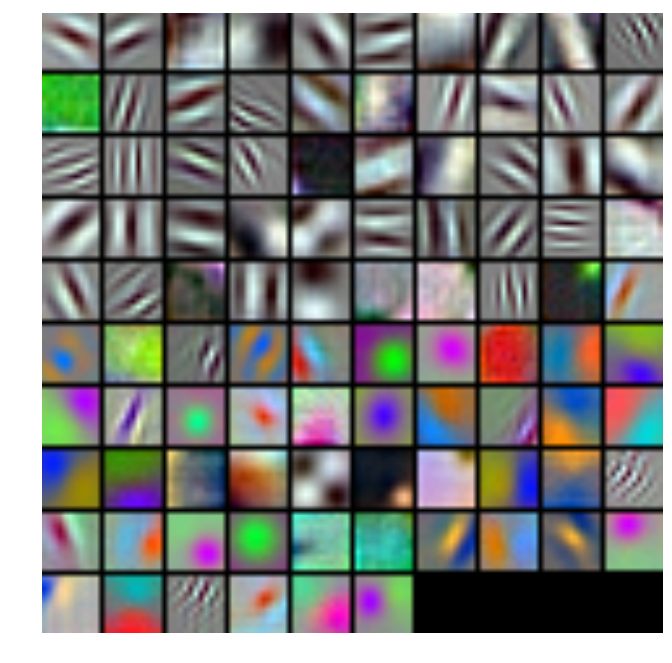

In [28]:
from vis_utils import visualize_grid
import matplotlib.pyplot as plt
grid = visualize_grid(solver.net.params['conv1'][0].data.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(8, 8)
plt.show()

## An example to show the probablity distribution over scenes of a test sample¶

The scenery is  bedroom
The prediction is:
bedroom :  0.823401
living_room :  0.0868421
dining_room :  0.0281322
study :  0.0204661
playroom :  0.0173469


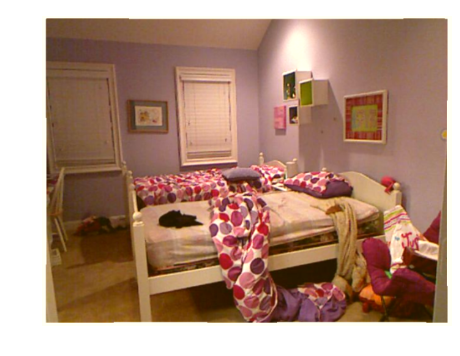

In [31]:
#An example to show the probablity distribution over scenes of a test sample¶
solver.test_nets[1].forward()
imshow(deprocess_net_image(solver.test_nets[1].blobs['data'].data[0]));axis('off')
index = int(solver.test_nets[1].blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

probs = solver.test_nets[1].blobs['probs'].data[0]
predict_index = probs.argmax()
num_tops = 5
highst_indexes = np.array(probs).argsort()[::-1][:num_tops]  # the top 5 probability of scenes
print 'The prediction is:'
for i in highst_indexes:
    print allSceneLabel['sceneName'][0][i-1][0],': ',probs[i]

The scenery is  bedroom
The prediction is:
bedroom :  0.921724
living_room :  0.0257225
study :  0.00915588
office :  0.00783212
bathroom :  0.00627356


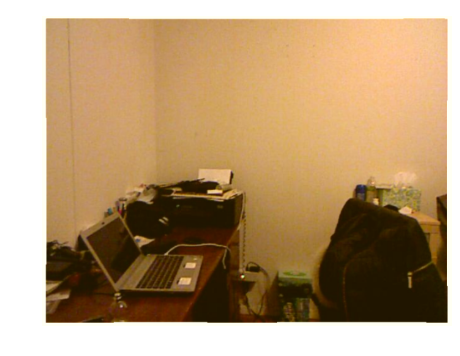

In [32]:
#An example to show the probablity distribution over scenes of a test sample¶
solver.test_nets[1].forward()
imshow(deprocess_net_image(solver.test_nets[1].blobs['data'].data[0]));axis('off')
index = int(solver.test_nets[1].blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

probs = solver.test_nets[1].blobs['probs'].data[0]
predict_index = probs.argmax()
num_tops = 5
highst_indexes = np.array(probs).argsort()[::-1][:num_tops]  # the top 5 probability of scenes
print 'The prediction is:'
for i in highst_indexes:
    print allSceneLabel['sceneName'][0][i-1][0],': ',probs[i]

In [129]:
del solver